## This notebooks show that we can reduce RMSE and MAE by 
- Limiting the departure delay from -15 to 179, and
- Assigning one category for early departure less than -15, and
- Assigning one category for departure delays larger than 179

## Importing the need packages

In [1]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import os

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

## Defining features and target(s)

In [3]:
features = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",

    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
    
    "CRS_DEP_TIME",
    "DEP_TIME_BLK",
    "CRS_ARR_TIME",
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
]

target = "DEP_DELAY_GROUP"

## Importing the training datasets

In [4]:
# Get the current script's directory
current_script_dir = os.getcwd()

# Move up to the parent directory
parent_dir = os.path.dirname(current_script_dir)

# Define the sibling data directory name
data_dir = os.path.join(parent_dir, 'data')

# Load the 2022 training datset
# Use os.path.join to create the full file path
training_dataset_filename = "encoded_training_dataset_2022.csv"
file_path = os.path.join(data_dir, training_dataset_filename)

# Read the CSV file into a DataFrame
dataset_df = pd.read_csv(file_path)
training_df = dataset_df[features+ [target]].copy()

# Display the DataFrame
display(training_df)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY_GROUP
0,1,1,1,6,20363,360,4732,10135,30135,42,23,11433,31295,26,43,1015,5,1209,7,114,425,2,-1
1,1,1,1,6,20363,360,5430,11433,31295,26,43,10135,30135,42,23,1422,9,1548,10,86,425,2,-1
2,1,1,1,6,20363,414,4671,10397,30397,13,34,14783,34783,29,64,2057,15,2149,16,112,563,3,-1
3,1,1,1,6,20363,414,5009,13487,31650,27,63,11423,31423,19,61,1041,5,1153,6,72,232,1,-1
4,1,1,1,6,20363,414,5083,11423,31423,19,61,10397,30397,13,34,1300,8,1610,11,130,743,3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551768,4,12,31,6,20452,5292,5741,12953,31703,36,22,11066,31066,39,44,830,3,1038,5,128,479,2,-1
6551769,4,12,31,6,20452,6245,3607,14321,34321,23,12,13930,30977,17,41,635,1,758,2,143,900,4,-1
6551770,4,12,31,6,20452,6245,3686,13930,30977,17,41,14321,34321,23,12,1800,13,2129,16,149,900,4,-1
6551771,4,12,31,6,20452,6245,3699,11003,31003,19,61,13930,30977,17,41,1508,10,1627,11,79,196,1,-1


In [5]:
training_df.dtypes

QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
OP_CARRIER_AIRLINE_ID    int64
TAIL_NUM                 int64
OP_CARRIER_FL_NUM        int64
ORIGIN_AIRPORT_ID        int64
ORIGIN_CITY_MARKET_ID    int64
ORIGIN_STATE_FIPS        int64
ORIGIN_WAC               int64
DEST_AIRPORT_ID          int64
DEST_CITY_MARKET_ID      int64
DEST_STATE_FIPS          int64
DEST_WAC                 int64
CRS_DEP_TIME             int64
DEP_TIME_BLK             int64
CRS_ARR_TIME             int64
ARR_TIME_BLK             int64
CRS_ELAPSED_TIME         int64
DISTANCE                 int64
DISTANCE_GROUP           int64
DEP_DELAY_GROUP          int64
dtype: object

In [6]:
categorical_columns = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",

    "DEP_DELAY_GROUP"
]

for column in categorical_columns:
    training_df[column] = training_df[column].astype('category')

In [7]:
training_df.dtypes

QUARTER                     int64
MONTH                       int64
DAY_OF_MONTH                int64
DAY_OF_WEEK                 int64
OP_CARRIER_AIRLINE_ID    category
TAIL_NUM                 category
OP_CARRIER_FL_NUM        category
ORIGIN_AIRPORT_ID        category
ORIGIN_CITY_MARKET_ID    category
ORIGIN_STATE_FIPS        category
ORIGIN_WAC               category
DEST_AIRPORT_ID          category
DEST_CITY_MARKET_ID      category
DEST_STATE_FIPS          category
DEST_WAC                 category
CRS_DEP_TIME                int64
DEP_TIME_BLK                int64
CRS_ARR_TIME                int64
ARR_TIME_BLK                int64
CRS_ELAPSED_TIME            int64
DISTANCE                    int64
DISTANCE_GROUP              int64
DEP_DELAY_GROUP          category
dtype: object

## Defining functions for model evaluation

In [8]:
def evaluate_model(data_df, features_columns, target_column):
    features = data_df[features_columns]
    target = data_df[target_column]

    accuracy_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    
    kf = KFold(n_splits=2, shuffle=True, random_state=123)
    
    for train_index, test_index in kf.split(features.values):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        model = xgb.XGBClassifier(
            enable_categorical=True,
            objective='multi:softmax', # multi:softmax used for multi-class
            num_class=len(target.unique()), 
            eval_metric='merror',
            random_state=123,
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')  # 'micro', 'macro', 'weighted'
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted')

        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        f1_scores.append(f1)
        
    return np.mean(accuracy_scores), np.mean(recall_scores), np.mean(precision_scores), np.mean(f1_scores)

## Training and Evaluation using 2-fold Cross Validation

## Try different minute intervall in hours

In [9]:
def generate_categories(intervall_in_minutes: int) -> dict:
    intervalls = {}

    intervalls[0] = {
        "min": float('-inf'),
        "max": -15
    }

    intervalls[1] = {
        "min": -15,
        "max": 0
    }

    for start in range(0, 181, intervall_in_minutes):
        end = 2 + start + intervall_in_minutes
        category = int(start/intervall_in_minutes)
        intervalls[category] = {
            "min": start,
            "max": end if start < 180 else float('+Inf')
        }

    return intervalls

In [10]:
# Function to categorize DEP_DELAY values
def categorize_minutes(minutes_value, intervalls):
    for category, category_limits in intervalls.items():
        if minutes_value >= category_limits["min"] and minutes_value < category_limits["max"]:
            return category
    return category

In [11]:
intervalls_array = []
intervall_accuracy_scores = []
intervall_recall_scores = []
intervall_precision_scores = []
intervall_f1_scores = []

for i in range(1, 61):
    if 60 % i == 0:
        intervall_in_minutes = int(60/i)
        intervalls_array.append(intervall_in_minutes)
        print(f"{intervall_in_minutes = }")
        intervalls = generate_categories(intervall_in_minutes=intervall_in_minutes)
        target_new = f'DEP_DELAY_GROUP_NEW_{intervall_in_minutes}'
        dataset_df[target_new] = dataset_df['DEP_DELAY'].apply(lambda x: categorize_minutes(x, intervalls))
        training_df_new = dataset_df[features+ [target_new]]
        acc_score, re_score, pre_score, f1 = evaluate_model(
            data_df=training_df_new, 
            features_columns=features, 
            target_column=target_new
        )
        intervall_accuracy_scores.append(acc_score)
        intervall_recall_scores.append(re_score)
        intervall_precision_scores.append(pre_score)
        intervall_f1_scores.append(f1)
        
        print("Evaluation: Accuracy Score:", acc_score)
        print("Evaluation: Recall Score:", re_score)
        print("Evaluation: Precision Score:", pre_score)
        print("Evaluation: F1 Score:", f1)
        print("----------------------------------------------------------")

intervall_in_minutes = 60
Evaluation: Accuracy Score: 0.6497686962365017
Evaluation: Recall Score: 0.6497686962365017
Evaluation: Precision Score: 0.6249470251042055
Evaluation: F1 Score: 0.616172467290374
----------------------------------------------------------
intervall_in_minutes = 30
Evaluation: Accuracy Score: 0.6200031655492965
Evaluation: Recall Score: 0.6200031655492965
Evaluation: Precision Score: 0.5610839794586855
Evaluation: F1 Score: 0.5577941958158853
----------------------------------------------------------
intervall_in_minutes = 20
Evaluation: Accuracy Score: 0.6033969736035595
Evaluation: Recall Score: 0.6033969736035595
Evaluation: Precision Score: 0.5077952456525379
Evaluation: F1 Score: 0.5225710614535619
----------------------------------------------------------
intervall_in_minutes = 15
Evaluation: Accuracy Score: 0.5935892467472492
Evaluation: Recall Score: 0.5935892467472492
Evaluation: Precision Score: 0.4773930188108284
Evaluation: F1 Score: 0.4998503468330

KeyboardInterrupt: 

## Plot all results

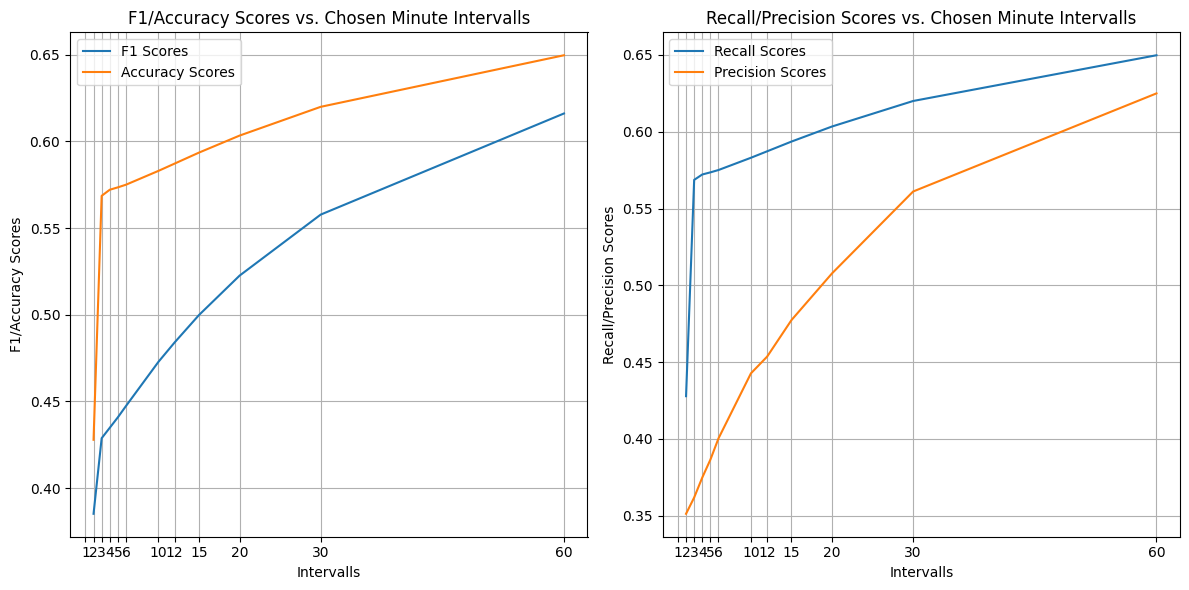

In [13]:
# Create a figure and set up subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy and F1 scores
ax1.plot(intervalls_array[0:11], intervall_f1_scores, label='F1 Scores')
ax1.plot(intervalls_array[0:11], intervall_accuracy_scores, label='Accuracy Scores')
ax1.set_title('F1/Accuracy Scores vs. Chosen Minute Intervalls')
ax1.set_xlabel('Intervalls')
ax1.set_ylabel('F1/Accuracy Scores')
ax1.set_xticks(intervalls_array)  # Limit x-axis ticks to those in intervalls
ax1.grid() # Turn on grid 
ax1.legend()

# Plot recall and precision scores
ax2.plot(intervalls_array[0:11], intervall_recall_scores, label='Recall Scores')
ax2.plot(intervalls_array[0:11], intervall_precision_scores, label='Precision Scores')
ax2.set_title('Recall/Precision Scores vs. Chosen Minute Intervalls')
ax2.set_xlabel('Intervalls')
ax2.set_ylabel('Recall/Precision Scores')
ax2.set_xticks(intervalls_array)  # Limit x-axis ticks to those in intervalls
ax2.grid() # Turn on grid 
ax2.legend()

# Display the plots
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

## Train model based on 1 minute intervall 
- from 0 to 179 minutes: One category per minute
- from 180 and over: One dedicated category for any delay larger than 3 hours
- from -1 to -15: One dedicated category for early departure larger than 15 minutes
- from -16 and lower: One dedicated category for any early departure smaller than 15 minutes. 

In [14]:
intervall_in_minutes = 1
intervalls = generate_categories(intervall_in_minutes=intervall_in_minutes)
target_new = 'DEP_DELAY_GROUP_NEW_1'
dataset_df[target_new] = dataset_df['DEP_DELAY'].apply(lambda x: categorize_minutes(x, intervalls))
training_df_new = dataset_df[features+ [target_new]]

In [15]:
model = xgb.XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=123
)
        
model.fit(training_df_new[features], training_df_new[target_new])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [16]:
# Load the 2023 testing datset
# Use os.path.join to create the full file path
testing_dataset_filename = "encoded_evaluation_dataset_2023.csv"
file_path = os.path.join(data_dir, testing_dataset_filename)

# Read the CSV file into a DataFrame
dataset_2023_df = pd.read_csv(file_path)
testing_df = dataset_2023_df[features+ ['DEP_DELAY']].copy()

In [17]:
intervalls = generate_categories(intervall_in_minutes=1)
target_new = 'DEP_DELAY_GROUP_NEW_1'
testing_df[target_new] = testing_df['DEP_DELAY'].apply(lambda x: categorize_minutes(x, intervalls))

In [18]:
# Display the DataFrame
display(testing_df)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY,DEP_DELAY_GROUP_NEW_1
0,1,1,1,7,20363,319,5244,13930,30977,17,41,12478,31703,36,22,1520,10,1841,13,141,740,3,4,4
1,1,1,1,7,20363,319,5317,12478,31703,36,22,13930,30977,17,41,945,4,1144,6,179,740,3,-4,-1
2,1,1,1,7,20363,319,5397,12478,31703,36,22,10581,30581,23,12,2100,16,2236,17,96,382,2,-4,-1
3,1,1,1,7,20363,332,5076,10397,30397,13,34,14783,34783,29,64,1130,6,1225,7,115,563,3,-5,-1
4,1,1,1,7,20363,332,5076,14783,34783,29,64,10397,30397,13,34,1400,9,1637,11,97,563,3,-6,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6763361,4,12,31,7,20452,5247,5680,10721,30721,25,13,11066,31066,39,44,1315,8,1538,10,143,640,3,-5,-1
6763362,4,12,31,7,20452,5247,5701,14122,30198,42,23,10721,30721,25,13,1038,5,1222,7,104,496,2,-7,-1
6763363,4,12,31,7,20452,6245,3428,10431,30431,37,36,13930,30977,17,41,1515,10,1627,11,132,536,3,-7,-1
6763364,4,12,31,7,20452,6245,3517,11193,33105,21,52,13930,30977,17,41,900,4,946,4,106,264,2,-7,-1


In [19]:
y_pred = model.predict(testing_df[features].values)

In [20]:
y_test = testing_df['DEP_DELAY_GROUP_NEW_1'].values

print("Using DEP_DELAY_GROUP_NEW_1 as target in a regressor trained with DEP_DELAY_GROUP_NEW_1")
testing_rmse_score = rmse(y_test, y_pred)
print(f"Evaluation: Root Mean Squared Error: {testing_rmse_score}")
testing_mae_score = mean_absolute_error(y_test, y_pred)
print(f"Evaluation: Mean Absolute Error: {testing_mae_score}")

Using DEP_DELAY_GROUP_NEW_1 as target in a regressor trained with DEP_DELAY_GROUP_NEW_1
Evaluation: Root Mean Squared Error: 31.765214346565326
Evaluation: Mean Absolute Error: 18.410472240274004


## Train a XGBoost Regressor using DEP_DELAY as target

In [21]:
target = 'DEP_DELAY'

model = xgb.XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=123
)
        
model.fit(dataset_df[features], dataset_df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [22]:
y_pred = model.predict(testing_df[features].values)

In [23]:
y_test = testing_df['DEP_DELAY'].values

print("Using DEP_DELAY as target in a regressor trained with DEP_DELAY")
testing_rmse_score = rmse(y_test, y_pred)
print(f"Evaluation: Root Mean Squared Error: {testing_rmse_score}")
testing_mae_score = mean_absolute_error(y_test, y_pred)
print(f"Evaluation: Mean Absolute Error: {testing_mae_score}")

Using DEP_DELAY as target in a regressor trained with DEP_DELAY
Evaluation: Root Mean Squared Error: 55.03864371797086
Evaluation: Mean Absolute Error: 22.981131763890577
